In [1]:
from openbb_terminal.sdk import openbb
import numpy as np
import pandas as pd
import scipy.stats as stats
import yfinance as yf
import datetime as dt
from scipy.integrate import quad
from scipy.optimize import minimize

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Load the option chains for a stock from a source

In [2]:
option_chain=openbb.stocks.options.load_options_chains('SPY','CBOE')

Clean up the data frame of the call price and implied volatility. Plot the resulting dataframe

,strike,expiration,impliedVolatility,lastTradePrice
386,454.0,2023-08-01,0.1210,4.00
388,455.0,2023-08-01,0.1140,3.16
390,456.0,2023-08-01,0.1124,2.33
392,457.0,2023-08-01,0.1055,1.54
394,458.0,2023-08-01,0.1013,0.95
...,...,...,...,...
4680,460.0,2023-10-20,0.1226,11.69
4686,465.0,2023-10-20,0.1165,8.75
5296,458.0,2023-12-15,0.1355,19.32
5298,459.0,2023-12-15,0.1344,18.47


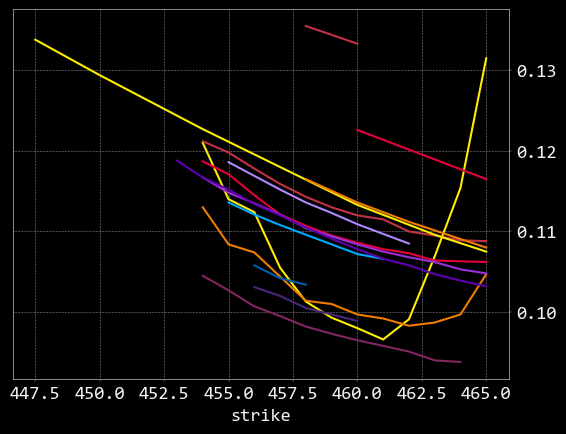

In [3]:
call_df = option_chain.chains[option_chain.chains.optionType=='call']

call_df = call_df[(call_df.optionType=='call') & (call_df.volume>1000) & (call_df.strike>option_chain.last_price-10) & (call_df.strike<option_chain.last_price+10)]

call_df = call_df[call_df.expiration != option_chain.chains.expiration.values[0]][['strike','expiration','impliedVolatility','lastTradePrice']]

call_df.set_index('strike').groupby('expiration').impliedVolatility.plot()

call_df


# Heston Model:

## under risk-neutral measure:
$$
dS_t= r S_t dt+\sqrt{v_t}S_t dW_{1,t}^\mathbb{Q}
\\
dv_t=\kappa(\theta-v_t)dt+\sigma\sqrt{v_t}dW_{2,t}^\mathbb{Q}
\\
dW_{1,t}^\mathbb{Q}dW_{2,t}^\mathbb{Q}=\rho dt
$$

## Call price using Quantpy

In [4]:
def heston_charfunc_quantpy(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    
    # constants
    b = kappa+lambd
    a = kappa*theta
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    return exp1*term2*exp2
   
def integrand_quantpy(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc_quantpy(phi-1j, *args) - K*heston_charfunc_quantpy(phi, *args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator / denominator

def heston_price_quantpy(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    # Use quadrature for numerical integration with proper bounds
    real_integral, err = quad(integrand_quantpy, 0, 100, args=args)
    
    # Calculate the option price
    option_price = (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi
    
    return option_price

In [5]:
S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
lambd = 0 # risk premium of variance
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity

heston_price_quantpy( S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r )

12.422227179891545

# Calibration of Heston parameters using call prices

In [10]:
params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.3]}, 
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.1, "lbub": [1e-3,0.3]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,0.5]},
          "rho": {"x0": -0.8, "lbub": [-1,0]}
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

r = 0.054

P = call_df.lastTradePrice.values

a = call_df.strike.values
b = np.array([((i-pd.to_datetime('today')).days +2)/365 for i in pd.to_datetime(call_df['expiration'].values).tolist()])
strike_and_mat = np.vstack((a, b)).T

def SqErr(x):
    v0, kappa, theta, sigma, rho = [param for param in x]
    
    MC_prices = np.array([heston_price_quantpy(S0, i[0], v0, kappa, theta, sigma, rho, 0, i[1], r)\
                          for i in strike_and_mat])
    
    err = np.sum( (P-MC_prices)**2 /len(P) )
          
    return err

result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP',options={'maxiter': 1e4 }, bounds=bnds)

In [11]:
result.x

array([ 0.3       ,  2.5648047 ,  0.3       ,  0.04775747, -0.00336758])